# Agent Coaching Recommendation Engine
Today, a Team Manager in SDS uses different tools to identify low performing agents. In order to find opportunities for improvement, he randomly selects contacts based on sic codes to manually deep dive and concludes weather the drop in associates performance is agent controllable or not. The aim of this analysis is to develop a more scientific way by calculating delivery success probability for a contact. Recommending DSR misses with high success probability (False Positive Cases) can significantly reduce time of team manager in selecting contacts and help him do targetting performance evaluation of his associates.

We have opportunity to isolate controllable vs uncontrollable factor to make our approach selective in manual deep dives and maximize the value created through exercise to improve DSR performance accross associates in different marketplaces.

## The Machine Learning Solution
The machine learning solution is required because the contact mix keeps changing over time. Hence, new parameters need to be updated over time and proportion of cases keeps on changing for non-parametric methods like tree based models. For this problem the following design was considered:
1. Develop a binary classification model to predict probability of a contact being DSR = 1 at the time it enters into the GACD System. Since, we are calculating probability at contact level, features that are available for an associate to see about a package are considered in building this model.
2. AUC-ROC is the model evaluation metric to be used as it tells the goodness of separation between probabilities for TPR and TNR.
3. The aim of the training model exercise is to minimize the false negative rate and maximize accuracy.

## Source Data and Feature Engineering
d_sds_modified_packcomms and dsr_variance_bridging_rawdata tables are utilized to get pre-contact features to build different models. Features are selected based on feature importance, statistical significance optimizing overall model accuracy. Following category of features are utilized to build the train set:
1. Difference between shipment event scan and contact connect time
2. Categorical variables like channel, site etc.
3. Binary variables showing if there was a scan prior to contact

## Algorithm Selection and Observations
Since we have formulated the business problem as a binary classification problem, we tried the following algorithms:
1. Logistic Regression
2. Random Forest
3. XGBoost

Both XGBoost and Random Forest perform equally good on the validation set and are better than logistic regression. The varible lm_wrong_delivery_station is not significant in all the models hence removed it from the analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('2c_train_data_jan_2021.txt', sep = '\t')
print(train_data.shape)

(263393, 32)


In [4]:
(train_data['delivered_in_48h'].value_counts()/train_data.shape[0])*100

1    70.408097
0    29.591903
Name: delivered_in_48h, dtype: float64

#### DSR for AMZL RECIPIENT US in Jan 2021 was 70.41%

## Exploratory Data Analysis

In [21]:
pd.set_option("display.max_columns",100)
train_data.head()

,packcomm_id,connect_date_datetime_local,disconnect_date_datetime_local,delivered_in_48h,lm_delivery_attempted_reasoncode,lm_ship_method,channel,site,lm_ead_contact_diff,lm_wrong_stattion_contact_diff,lm_delay_contact_diff,lm_missing_contact_diff,lm_shipped_contact_diff,lm_inducted_contact_diff,lm_dispatched_contact_diff,lm_exception_contact_diff,lm_customer_rejected_prior_during_contact,lm_hold_for_customer_request,lm_contact_48h_prior_ead,lm_transport_started_prior_contact,lm_package_shipped_prior_contact,lm_package_inducted_prior_contact,lm_wrong_station_prior_contact,lm_delayed_at_station_prior_contact,lm_delayed_prior_contact,lm_missing_prior_contact,lm_hold_for_action_prior_contact,lm_hold_for_redelivery_prior_contact,lm_delivery_exception_prior_contact,lm_damaged_prior_contact,lm_undeliverable_prior_contact,lm_dispatched_prior_contact
0,111-7534854-1820242:TBA145418564504:1026132413905,2021-01-26 10:48:07,2021-01-26 11:08:28,1,no_delivery_attempted,premium,Voice,DBX,-14.0,0,13,0,62,31,24,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1
1,112-2339165-1025836:TBA125404423304:1025441763115,2021-01-06 09:47:04,2021-01-06 09:56:14,0,no_delivery_attempted,premium,Voice,VCS-IND,59.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,701-4080882-2739402:TBC176546671009:1025995478455,2021-01-21 22:32:13,2021-01-21 22:34:51,1,unable_to_access,premium,Voice,VCS-CRI,-2.0,0,0,0,41,18,12,5,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1
3,701-8249098-6755414:TBC169692771009:1025501341795,2021-01-07 19:38:08,2021-01-07 19:48:46,0,no_delivery_attempted,premium,Voice,VCS-USA,121.0,0,0,0,50,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,114-4855369-9758655:TBA154384929201:1026207325205,2021-01-28 11:08:07,2021-01-28 11:17:37,1,business_closed,lma,Voice,VCS-USA,-15.0,0,18,0,63,39,24,19,0,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1


In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263393 entries, 0 to 263392
Data columns (total 32 columns):
packcomm_id                                  263393 non-null object
connect_date_datetime_local                  263393 non-null object
disconnect_date_datetime_local               263393 non-null object
delivered_in_48h                             263393 non-null int64
lm_delivery_attempted_reasoncode             263393 non-null object
lm_ship_method                               263393 non-null object
channel                                      263393 non-null object
site                                         263393 non-null object
lm_ead_contact_diff                          263390 non-null float64
lm_wrong_stattion_contact_diff               263393 non-null int64
lm_delay_contact_diff                        263393 non-null int64
lm_missing_contact_diff                      263393 non-null int64
lm_shipped_contact_diff                      263393 non-null int64
lm_induct

df.info() gives us the information about how unoptimized the storage of the python data types are. For binary variables, we don't need so much space and hence int64 is an overkill. Changing datatypes can reduce our memory usuage significantly. We will take care about this when we built productionalized pipelines.

In [23]:
(train_data.isna().sum()/train_data.shape[0])*100

packcomm_id                                  0.000000
connect_date_datetime_local                  0.000000
disconnect_date_datetime_local               0.000000
delivered_in_48h                             0.000000
lm_delivery_attempted_reasoncode             0.000000
lm_ship_method                               0.000000
channel                                      0.000000
site                                         0.000000
lm_ead_contact_diff                          0.001139
lm_wrong_stattion_contact_diff               0.000000
lm_delay_contact_diff                        0.000000
lm_missing_contact_diff                      0.000000
lm_shipped_contact_diff                      0.000000
lm_inducted_contact_diff                     0.000000
lm_dispatched_contact_diff                   0.000000
lm_exception_contact_diff                    0.000000
lm_customer_rejected_prior_during_contact    0.000000
lm_hold_for_customer_request                 0.000000
lm_contact_48h_prior_ead    

There are no missing values except a few in lm_ead_contact_diff, replacing them with 0

In [24]:
train_data['lm_ead_contact_diff'] = train_data['lm_ead_contact_diff'].fillna(value = 0.0)

In [25]:
train_data.describe()

,delivered_in_48h,lm_ead_contact_diff,lm_wrong_stattion_contact_diff,lm_delay_contact_diff,lm_missing_contact_diff,lm_shipped_contact_diff,lm_inducted_contact_diff,lm_dispatched_contact_diff,lm_exception_contact_diff,lm_customer_rejected_prior_during_contact,lm_hold_for_customer_request,lm_contact_48h_prior_ead,lm_transport_started_prior_contact,lm_package_shipped_prior_contact,lm_package_inducted_prior_contact,lm_wrong_station_prior_contact,lm_delayed_at_station_prior_contact,lm_delayed_prior_contact,lm_missing_prior_contact,lm_hold_for_action_prior_contact,lm_hold_for_redelivery_prior_contact,lm_delivery_exception_prior_contact,lm_damaged_prior_contact,lm_undeliverable_prior_contact,lm_dispatched_prior_contact
count,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000,263393.000000
mean,0.704081,6.961434,0.064094,2.583277,2.767572,47.854985,16.067549,10.464280,6.528366,0.019139,0.016022,0.129130,0.578497,0.843470,0.611808,0.002126,0.087117,0.023938,0.073051,0.174063,0.168395,0.393830,0.005718,0.011177,0.573409
std,0.456456,50.621386,2.749649,14.537132,17.202822,55.674198,29.008084,25.056446,21.953647,0.137013,0.125559,0.335345,0.493801,0.363358,0.487340,0.046061,0.282007,0.152855,0.260220,0.379164,0.374217,0.488599,0.075399,0.105130,0.494583
min,0.000000,-4178.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-5.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,0.000000,0.000000,0.000000,35.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,27.000000,0.000000,0.000000,0.000000,63.000000,18.000000,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,985.000000,503.000000,883.000000,2165.000000,4224.000000,1253.000000,1253.000000,887.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


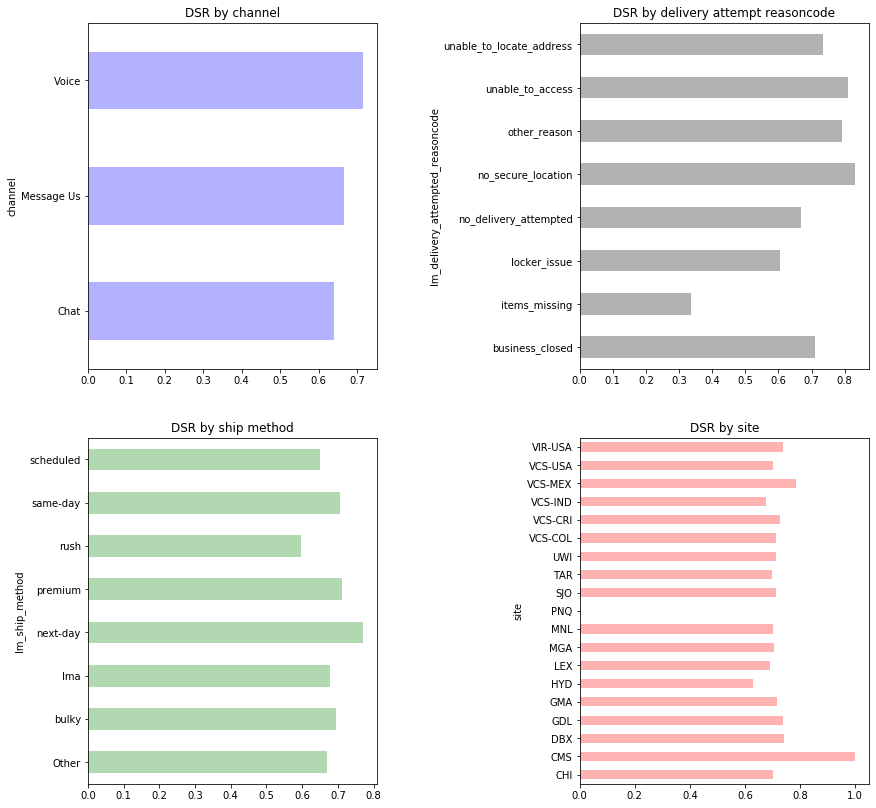

In [26]:
fig, ax = plt.subplots(2,2, figsize=(14,14))
plt.subplots_adjust(wspace=0.7, hspace=0.2)
ax[0,0].set_title("DSR by channel")
train_data.groupby(['channel']).mean()['delivered_in_48h'].plot.barh(ax=ax[0,0], color='b', alpha = 0.3)
ax[1,0].set_title("DSR by ship method")
train_data.groupby(['lm_ship_method']).mean()['delivered_in_48h'].plot.barh(ax=ax[1,0], color='g', alpha=0.3)
ax[0,1].set_title("DSR by delivery attempt reasoncode")
train_data.groupby(['lm_delivery_attempted_reasoncode']).mean()['delivered_in_48h'].plot.barh(ax=ax[0,1], color='k', alpha=0.3)
ax[1,1].set_title("DSR by site")
train_data.groupby(['site']).mean()['delivered_in_48h'].plot.barh(ax=ax[1,1], color='r', alpha=0.3)
plt.show()

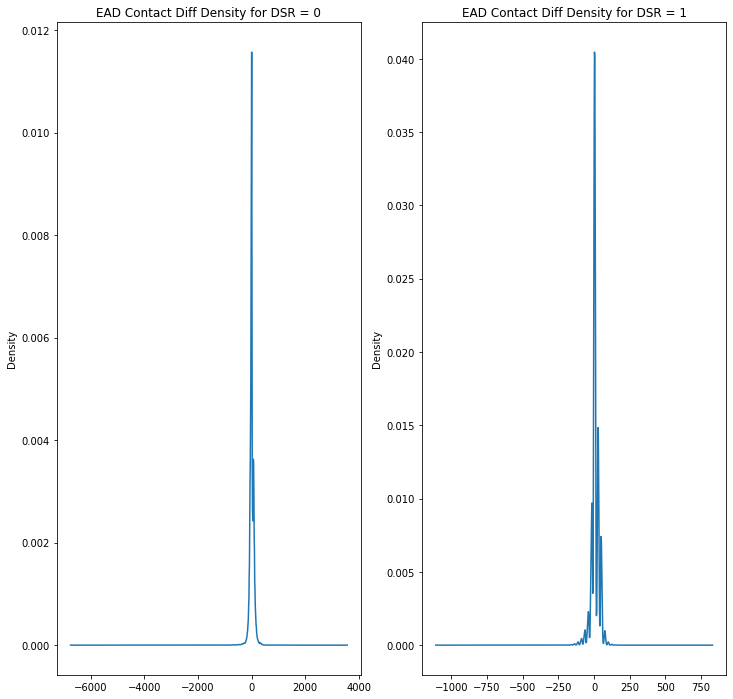

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12,12)) 
ax[0].set_title("EAD Contact Diff Density for DSR = 0")
train_data['lm_ead_contact_diff'][train_data['delivered_in_48h'] == 0].plot.density(ax=ax[0])
ax[1].set_title("EAD Contact Diff Density for DSR = 1")
train_data['lm_ead_contact_diff'][train_data['delivered_in_48h'] == 1].plot.density(ax=ax[1])
plt.show()

## Handling the class imbalance
We run the model on both balanced and unbalanced dataset and compare performance in accuracy

In [32]:
train_1 = train_data[train_data['delivered_in_48h']==1].sample(frac=0.42, replace=False, random_state = 23)
train_0 = train_data[train_data['delivered_in_48h']==0]

train_data_balanced = pd.concat([train_1,train_0])
print(train_data_balanced.shape)
train_data_balanced['delivered_in_48h'].value_counts()

(155832, 32)


0    77943
1    77889
Name: delivered_in_48h, dtype: int64

## Outlier Detection and Removal
lm_EAD_contact_diff is the most important feature in every model and from business perspective, it makes sense because if the package is 48 hour prior to the estimated arrival datetime, it is less likely to get delivered. Programatically, for some ship methods like 1-day delivery, 2-day delivery this might never make sense but for all other standard deliveries it can help us to prevent a huge chunk of less-controllable contacts from being routed to SDS. Now we will try to understand the distribution of this feature and try to find the optimal split for this features for maximum probability of getting a successful DSR.


The range of this feature clearly shows presence of outliers in the model, we would want to inspect these outlier cases and take a decision to fix them or remove them

In [37]:
train_data_balanced['lm_ead_contact_diff'].describe()

count    155832.000000
mean          6.331761
std          61.861568
min       -4178.000000
25%         -15.000000
50%           4.000000
75%          28.000000
max         985.000000
Name: lm_ead_contact_diff, dtype: float64

In [13]:
train_data_balanced['lm_ead_contact_diff'].sort_values().value_counts(bins=10)

(-47.6, 468.7]          246225
(-563.9, -47.6]          17002
(-1080.2, -563.9]          112
(468.7, 985.0]              41
(-1596.5, -1080.2]           6
(-2112.8, -1596.5]           2
(-2629.1, -2112.8]           1
(-4183.164, -3661.7]         1
(-3145.4, -2629.1]           0
(-3661.7, -3145.4]           0
Name: lm_ead_contact_diff, dtype: int64

In [29]:
subset = train_data_balanced.delivered_in_48h[(train_data_balanced.lm_ead_contact_diff < -168) | 
                                              (train_data_balanced['lm_ead_contact_diff'] > 168)]

print(subset.shape)
print("Total DSR = 1 cases in this bucket", subset.sum())

(2830,)
Total DSR = 1 cases in this bucket 23


Based on the above bins and using some business knowledge, contacts that are coming before or after 7 days of EAD (lm_ead_contact_diff feature < - 168 or lm_ead_contact_diff feature > 168) are less controllable and provide no value in defining delivery success probability. Hence, we will remove them from the training data set. 
(Total 2830 observations are being removed)

In [41]:
train_data_balanced = train_data_balanced[(train_data_balanced['lm_ead_contact_diff'] > -168) &
                                              (train_data_balanced['lm_ead_contact_diff'] < 168)]
train_data_balanced.shape

(152949, 32)

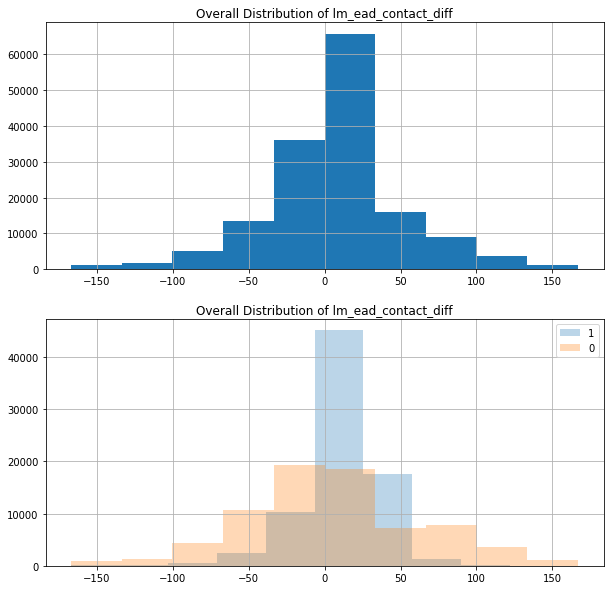

In [50]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].set_title("Overall Distribution of lm_ead_contact_diff")
train_data_balanced['lm_ead_contact_diff'].hist(ax=ax[0])
ax[1].set_title("Overall Distribution of lm_ead_contact_diff")
train_data_balanced['lm_ead_contact_diff'][train_data['delivered_in_48h']==1].hist(ax=ax[1], alpha=0.3, label=1)
train_data_balanced['lm_ead_contact_diff'][train_data['delivered_in_48h']==0].hist(ax=ax[1], alpha=0.3, label=0)
ax[1].legend()
plt.show()

Now the distribution of lm_ead_contact_diff looks more like a normal distribution and we can notice some difference in the distribution for DSR=1 and DSR=0

# Data Preparation for Model Training

In [51]:
numerical_features = ['lm_ead_contact_diff', 'lm_wrong_stattion_contact_diff', 'lm_delay_contact_diff', 
                      'lm_missing_contact_diff', 'lm_shipped_contact_diff', 'lm_inducted_contact_diff',
                      'lm_dispatched_contact_diff', 'lm_exception_contact_diff']

categorical_features = ['channel','lm_delivery_attempted_reasoncode','site','lm_ship_method']

binary_features = ['lm_customer_rejected_prior_during_contact',
                   'lm_hold_for_customer_request', 'lm_contact_48h_prior_ead',
                   'lm_transport_started_prior_contact',
                   'lm_package_shipped_prior_contact', 'lm_package_inducted_prior_contact',
                   'lm_wrong_station_prior_contact', 'lm_delayed_at_station_prior_contact',
                   'lm_delayed_prior_contact', 'lm_missing_prior_contact',
                   'lm_hold_for_action_prior_contact',
                   'lm_hold_for_redelivery_prior_contact',
                   'lm_delivery_exception_prior_contact', 'lm_damaged_prior_contact',
                   'lm_undeliverable_prior_contact', 'lm_dispatched_prior_contact']

label = ['delivered_in_48h']
ID = ['packcomm_id']

df_train = train_data[numerical_features + binary_features + ID + label].reset_index(drop=True)
df_train_balanced = train_data_balanced[numerical_features + binary_features + ID + label].reset_index(drop=True)
print(df_train.shape, df_train_balanced.shape)

(263393, 26) (152949, 26)


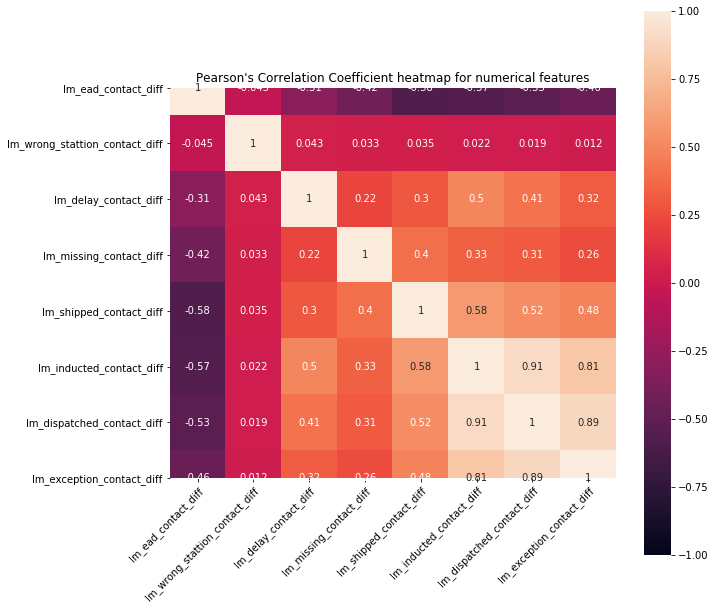

In [52]:
import seaborn as sn
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title("Pearson's Correlation Coefficient heatmap for numerical features")
ax = sn.heatmap(df_train_balanced[numerical_features].corr(), 
           vmin = -1.0, vmax = 1.0, annot=True, square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

lm_ead_contact_diff is highly correlated to all the other numerical features except lm_wrong_station_contact_diff. This might create issue of multicolinearity in linear models. This was expected as these events occur in succession but might be useful in non-parametric tree based models specially random forecast that uses bagging to select random features to build weak learners

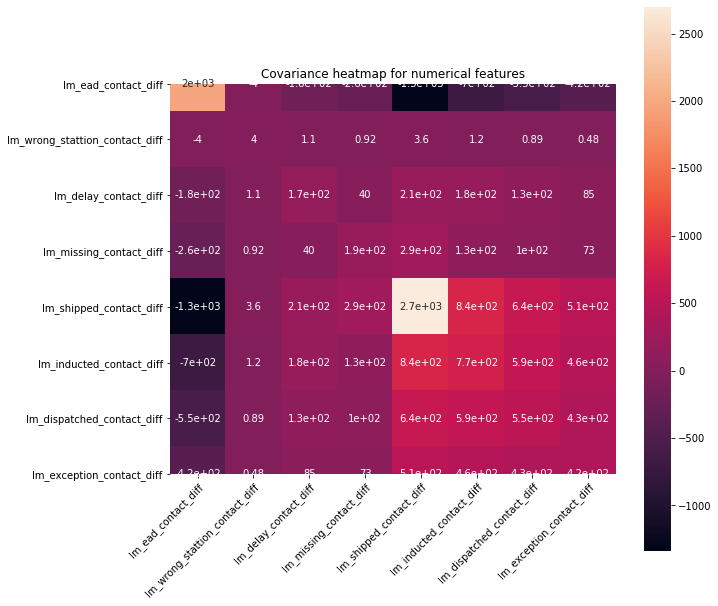

In [53]:
import seaborn as sn
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title("Covariance heatmap for numerical features")
ax = sn.heatmap(df_train_balanced[numerical_features].cov(), annot=True, square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

In [15]:
# from sklearn.preprocessing import OneHotEncoder
# preprocessing = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=True)

# df_cat_train = pd.DataFrame(preprocessing.fit_transform(df_train[categorical_features]).toarray()
#                       , columns=preprocessing.get_feature_names())

# df_cat_test = pd.DataFrame(preprocessing.transform(df_test[categorical_features]).toarray()
#                       , columns=preprocessing.get_feature_names())
# print(df_cat_train.shape, df_cat_test.shape)
# df_train = pd.concat([df_train, df_cat_train], axis=1)
# df_test = pd.concat([df_test, df_cat_test], axis=1)
# print(df_train.shape,df_test.shape)

In [16]:
# onehotencoded_features = list(preprocessing.get_feature_names())
# model_features = numerical_features + binary_features + onehotencoded_features

# df_model = df_train[numerical_features+binary_features+label+onehotencoded_features+ID]
# df_test = df_test[numerical_features+binary_features+label+onehotencoded_features+ID]

# print(df_model.shape,df_test.shape)
# df_model.head()

In [54]:
model_features = numerical_features + binary_features

In [61]:
from sklearn.model_selection import train_test_split
train_x, validation_x, train_y, validation_y = train_test_split(df_train_balanced[model_features+ID], 
                                                                df_train_balanced[label+ID],
                                                                test_size=0.2, random_state=23, shuffle=True)
print("Train X Set Size", train_x.shape)
print("Validation X Set Size", validation_x.shape)
print("Train Y Set Size", train_y.shape)
print("Validation Y Set Size", validation_y.shape)

Train X Set Size (122359, 25)
Validation X Set Size (30590, 25)
Train Y Set Size (122359, 2)
Validation Y Set Size (30590, 2)


# Binary Logistic Regression

In [74]:
from time import time
start_time = time()
import statsmodels.api as sm

model_features = binary_features + ['lm_ead_contact_diff']

x = train_x[model_features]
y = train_y[label]
lr_amzl_recipient = sm.Logit(y,x).fit()
print("Total time taken to train the model in seconds", (time() - start_time))

Optimization terminated successfully.
         Current function value: 0.545018
         Iterations 9
Total time taken to train the model in seconds 0.18827295303344727


In [75]:
lr_amzl_recipient.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       delivered_in_48h   No. Observations:               122359
Model:                          Logit   Df Residuals:                   122342
Method:                           MLE   Df Model:                           16
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                  0.2136
Time:                        23:09:48   Log-Likelihood:                -66688.
converged:                       True   LL-Null:                       -84796.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
lm_customer_rejected_prior_during_contact    -5.6620      0.214    -26.411      0.000      -6.082      -5.242
lm_hold_for_customer_request                 -0.8225      0.052    -15.914      0.000      -0.924      -0.721
lm_contact_48h_prior_ead                     -2.5741      0.029    -90.022      0.000      -2.630      -2.518
lm_transport_started_prior_contact           -0.5634      0.016    -35.138      0.000      -0.595      -0.532
lm_package_shipped_prior_contact              0.2070      0.016     13.287      0.000       0.176       0.238
lm_package_inducted_prior_contact             1.1397      0.026     44.269      0.000       1.089       1.190
lm_wrong_station_prior_contact               -0.0565      0.150     -0.377      0.706      -0.350       0.237
lm_delayed_at_station_prior_contact          -0.0710      0.025     -2.787      0.005      -0.121      -0.021
lm_delayed_prior_contact                     -0.2439      0.047     -5.183      0.000      -0.336      -0.152
lm_missing_prior_contact                     -1.5025      0.029    -51.874      0.000      -1.559      -1.446
lm_hold_for_action_prior_contact             -0.2518      0.019    -13.390      0.000      -0.289      -0.215
lm_hold_for_redelivery_prior_contact          0.0934      0.022      4.203      0.000       0.050       0.137
lm_delivery_exception_prior_contact          -0.7452      0.024    -30.610      0.000      -0.793      -0.698
lm_damaged_prior_contact                     -1.0010      0.186     -5.396      0.000      -1.365      -0.637
lm_undeliverable_prior_contact               -2.7001      0.098    -27.655      0.000      -2.891      -2.509
lm_dispatched_prior_contact                   0.6958      0.024     28.979      0.000       0.649       0.743
lm_ead_contact_diff                           0.0153      0.000     54.878      0.000       0.015       0.016
=============================================================================================================
"""

In [76]:
from time import time
start_time = time()
lr_train_y_pred_proba = lr_amzl_recipient.predict(train_x[model_features])
lr_validation_y_pred_proba = lr_amzl_recipient.predict(validation_x[model_features])
lr_validation_y_pred_value = (lr_validation_y_pred_proba > 0.5).astype(int)
print("Total time taken to predict on the validation set in seconds", (time() - start_time))

Total time taken to predict on the validation set in seconds 0.030733108520507812


In [77]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support,classification_report,roc_auc_score

print('AMZL Recipient Train AUC score:', roc_auc_score(train_y[label], lr_train_y_pred_proba))
print('AMZL Recipient Validation AUC score:', roc_auc_score(validation_y[label], lr_validation_y_pred_proba))

print('AMZL Recipient Validation Accuracy:', accuracy_score(validation_y[label], lr_validation_y_pred_value))
print('AMZL Recipient Validation Confusion Matrix: \n', confusion_matrix(validation_y[label], lr_validation_y_pred_value))
print(classification_report(validation_y[label], lr_validation_y_pred_value))

print(precision_recall_fscore_support(validation_y[label], lr_validation_y_pred_value))

AMZL Recipient Train AUC score: 0.7911450603219627
AMZL Recipient Validation AUC score: 0.7909598866150978
AMZL Recipient Validation Accuracy: 0.7560313828048382
AMZL Recipient Validation Confusion Matrix: 
 [[10118  4798]
 [ 2665 13009]]
              precision    recall  f1-score   support

           0       0.79      0.68      0.73     14916
           1       0.73      0.83      0.78     15674

    accuracy                           0.76     30590
   macro avg       0.76      0.75      0.75     30590
weighted avg       0.76      0.76      0.75     30590

(array([0.79151999, 0.7305554 ]), array([0.67833199, 0.8299732 ]), array([0.73056789, 0.77709746]), array([14916, 15674]))


# Random Forest Classifier

In [81]:
from time import time
start_time = time()
from sklearn.ensemble import RandomForestClassifier
rfc_amzl_recipient = RandomForestClassifier(n_estimators=100,
                                            criterion='entropy',
                                            max_depth= 12, 
                                            min_samples_leaf=10, 
                                            max_features=0.6,
                                            random_state=23,
                                            max_samples=0.8,
                                            n_jobs=-1)

# Train the classifier
model_features = numerical_features + binary_features
rfc_amzl_recipient.fit(train_x[model_features], train_y[label])
print("Total time taken to train the model (seconds)", (time() - start_time))

Total time taken to train the model (seconds) 3.304327964782715


In [82]:
from time import time
start_time = time()
train_y_pred_proba = rfc_amzl_recipient.predict_proba(train_x[model_features])[:,1]
validation_y_pred_proba = rfc_amzl_recipient.predict_proba(validation_x[model_features])[:,1]
validation_y_pred_value = rfc_amzl_recipient.predict(validation_x[model_features])
print("Total time taken to predict on the validation set in seconds", (time() - start_time))

Total time taken to predict on the validation set in seconds 0.5816030502319336


In [83]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support,classification_report,roc_auc_score

print('AMZL Recipient Train AUC score:', roc_auc_score(train_y[label], train_y_pred_proba))
print('AMZL Recipient Validation AUC score:', roc_auc_score(validation_y[label], validation_y_pred_proba))

print('AMZL Recipient Validation Accuracy:', accuracy_score(validation_y[label], validation_y_pred_value))
print('AMZL Recipient Validation Confusion Matrix: \n', confusion_matrix(validation_y[label], validation_y_pred_value))
print(classification_report(validation_y[label], validation_y_pred_value))

print(precision_recall_fscore_support(validation_y[label], validation_y_pred_value))

AMZL Recipient Train AUC score: 0.8738013353362729
AMZL Recipient Validation AUC score: 0.8668452440039963
AMZL Recipient Validation Accuracy: 0.7967636482510624
AMZL Recipient Validation Confusion Matrix: 
 [[10568  4348]
 [ 1869 13805]]
              precision    recall  f1-score   support

           0       0.85      0.71      0.77     14916
           1       0.76      0.88      0.82     15674

    accuracy                           0.80     30590
   macro avg       0.81      0.79      0.79     30590
weighted avg       0.80      0.80      0.80     30590

(array([0.8497226 , 0.76048036]), array([0.70850094, 0.88075794]), array([0.77271232, 0.8162119 ]), array([14916, 15674]))


In [84]:
feature_importances = pd.DataFrame(rfc_amzl_recipient.feature_importances_,
                                   index = train_x[model_features].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances['importance'] = feature_importances['importance'].round(5)

print('AMZL Recipient Predictive Model Feature Importance: \n', feature_importances)

AMZL Recipient Predictive Model Feature Importance: 
                                            importance
lm_ead_contact_diff                           0.41834
lm_customer_rejected_prior_during_contact     0.10438
lm_shipped_contact_diff                       0.06933
lm_missing_contact_diff                       0.06441
lm_package_inducted_prior_contact             0.05586
lm_inducted_contact_diff                      0.05464
lm_transport_started_prior_contact            0.05040
lm_missing_prior_contact                      0.02912
lm_contact_48h_prior_ead                      0.02590
lm_dispatched_contact_diff                    0.02482
lm_undeliverable_prior_contact                0.02382
lm_dispatched_prior_contact                   0.01770
lm_hold_for_redelivery_prior_contact          0.00978
lm_exception_contact_diff                     0.00967
lm_delivery_exception_prior_contact           0.00923
lm_package_shipped_prior_contact              0.00896
lm_delay_contact_diff       

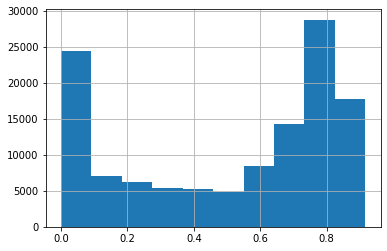

In [85]:
pd.Series(train_y_pred_proba).hist()

In [87]:
for threshold in [0.45,0.5,0.55,0.6,0.65]:
    validation_y_pred_value = (validation_y_pred_proba > threshold).astype(int)
    print('AMZL Recipient Validation Accuracy for ' + str(threshold), accuracy_score(validation_y[label], validation_y_pred_value))

AMZL Recipient Validation Accuracy for 0.45 0.7955867930696306
AMZL Recipient Validation Accuracy for 0.5 0.7967636482510624
AMZL Recipient Validation Accuracy for 0.55 0.797548218372017
AMZL Recipient Validation Accuracy for 0.6 0.7938868911408957
AMZL Recipient Validation Accuracy for 0.65 0.7783589408303367


Accuracy metric is maximized at a threshold value of 0.55

# XGBoost Classifier

In [88]:
from xgboost import XGBClassifier

In [89]:
from time import time
start_time = time()
xgb_amzl_recipient = XGBClassifier(objective = 'binary:logistic'
                                   ,n_estimators = 100
                                   ,learning_rate = 0.02
                                   ,gamma=10
                                   ,max_depth = 12
                                   ,reg_alpha=0.3
                                   ,random_state=23)

xgb_amzl_recipient.fit(train_x[model_features], train_y[label], eval_metric='logloss')
print("Total time taken to train the model (minutes)", (time() - start_time)/60)

Total time taken to train the model (minutes) 0.8596471468607585


In [90]:
from time import time
start_time = time()
train_y_pred_proba = xgb_amzl_recipient.predict_proba(train_x[model_features])[:,1]

validation_y_pred_proba = xgb_amzl_recipient.predict_proba(validation_x[model_features])[:,1]
validation_y_pred_value = xgb_amzl_recipient.predict(validation_x[model_features])

print("Total time taken to predict in seconds", (time() - start_time))

Total time taken to predict in seconds 1.6093902587890625


In [91]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support,classification_report,roc_auc_score
print('AMZL Recipient Train AUC score:', roc_auc_score(train_y[label], train_y_pred_proba))
print('AMZL Recipient Validation AUC score:', roc_auc_score(validation_y[label], validation_y_pred_proba))
print('AMZL Recipient Validation Accuracy:', accuracy_score(validation_y[label], validation_y_pred_value))
print('AMZL Recipient Validation Confusion Matrix: \n', confusion_matrix(validation_y[label], validation_y_pred_value))
print(classification_report(validation_y[label], validation_y_pred_value))

precision_recall_fscore_support(validation_y[label], validation_y_pred_value)

AMZL Recipient Train AUC score: 0.8709209749034328
AMZL Recipient Validation AUC score: 0.867272311264377
AMZL Recipient Validation Accuracy: 0.7975809087937235
AMZL Recipient Validation Confusion Matrix: 
 [[10568  4348]
 [ 1844 13830]]
              precision    recall  f1-score   support

           0       0.85      0.71      0.77     14916
           1       0.76      0.88      0.82     15674

    accuracy                           0.80     30590
   macro avg       0.81      0.80      0.80     30590
weighted avg       0.80      0.80      0.80     30590



(array([0.8514341 , 0.76080977]),
 array([0.70850094, 0.88235294]),
 array([0.7734192 , 0.81708614]),
 array([14916, 15674]))

In [92]:
feature_importances = pd.DataFrame(xgb_amzl_recipient.feature_importances_,
                                   index = train_x[model_features].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances['importance'] = feature_importances['importance'].round(5)

pd.set_option('display.max_rows', 100)
print('AMZL Recipient Predictive Model Feature Importance: \n', feature_importances)

AMZL Recipient Predictive Model Feature Importance: 
                                            importance
lm_ead_contact_diff                           0.20002
lm_customer_rejected_prior_during_contact     0.19962
lm_package_inducted_prior_contact             0.14711
lm_missing_contact_diff                       0.05859
lm_hold_for_redelivery_prior_contact          0.04864
lm_transport_started_prior_contact            0.04614
lm_missing_prior_contact                      0.03876
lm_undeliverable_prior_contact                0.03578
lm_dispatched_prior_contact                   0.02566
lm_delivery_exception_prior_contact           0.02424
lm_package_shipped_prior_contact              0.02423
lm_shipped_contact_diff                       0.02303
lm_inducted_contact_diff                      0.01911
lm_damaged_prior_contact                      0.01813
lm_dispatched_contact_diff                    0.01703
lm_delayed_at_station_prior_contact           0.01473
lm_delay_contact_diff       

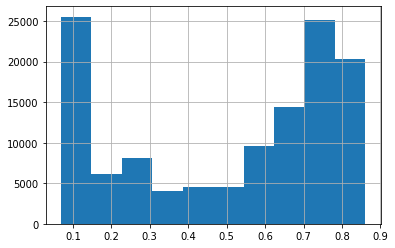

In [93]:
pd.Series(train_y_pred_proba).hist()

In [95]:
for threshold in [0.45,0.5,0.55,0.6,0.65]:
    validation_y_pred_value = (validation_y_pred_proba > threshold).astype(int)
    print('AMZL Recipient Validation Accuracy for ' + str(threshold), accuracy_score(validation_y[label], validation_y_pred_value))

AMZL Recipient Validation Accuracy for 0.45 0.795096436744034
AMZL Recipient Validation Accuracy for 0.5 0.7975809087937235
AMZL Recipient Validation Accuracy for 0.55 0.7981366459627329
AMZL Recipient Validation Accuracy for 0.6 0.7882968290290945
AMZL Recipient Validation Accuracy for 0.65 0.774076495586793


#### Model Accuracy also shows that DSR for AMZL RECIPIENT US should have been around 80% compared to 70%, an opportunity of improving 1000 bps by making programatic and operational initiatives solely based on historical delivery scans of a package. The false positive cases can be deep dived by team/group managers to identify agent coaching opportunities

# Future Scope
1. Hyper-parameter tuning
2. Adding more features